# Air Passenger Prediction with ARIMA

**Kyu Cho  
October 16, 2016**

# Table of Contents

1. Data Exploration
2. Checking Stationarity of a Time Series
    + Time Series Stationary Properties
3. Estimating & Eliminating Trend
    + Smoothing with Moving Average(MA)
        + Stationarity Test
    + Smoothing with Exponentially Weighted Moving Average(EWMA)
        + Stationarity Test
4. Eliminating Trend and Seasonality
    + Differencing
        + Stationarity Test
    + Decomposing
        + Stationarity Test
5. Forecasting a Time Series
    + ARIMA - Auto Regressive Integrated Moving Averages (linear regression)
        + ACF and PACF
    + Build AR Model - (p)
    + Build MA Model - (q)
    + Build Combined Model
6. Taking it back to original scale

# 1. Data Exploration

In [1]:
import os
os.chdir('C:\Users\Kyu\Google Drive\Portfolio\project 107')

from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [2]:
data = pd.read_csv('AirPassengers.csv')
display(data.shape)
display(data.head(3))
display(data.describe())
display(data.info())

# check factor variable levels
display("Checking factor variable levels")
display(data.apply(lambda x: len(x.unique())))

(144, 2)

Month  #Passengers
0  1949-01          112
1  1949-02          118
2  1949-03          132

#Passengers
count   144.000000
mean    280.298611
std     119.966317
min     104.000000
25%     180.000000
50%     265.500000
75%     360.500000
max     622.000000

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
Month          144 non-null object
#Passengers    144 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.3+ KB


None

'Checking factor variable levels'

Month          144
#Passengers    118
dtype: int64

- have to pass special arguments to the read_csv command for time series data set

In [3]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
data = pd.read_csv('AirPassengers.csv', parse_dates='Month', index_col='Month', date_parser=dateparse)
print(data.head())

            #Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-03-01          132
1949-04-01          129
1949-05-01          121


**parse_dates**: This specifies the column which contains the date-time information, the column name is ‘Month’.  
**index_col**: A key idea behind using Pandas for TS data is that the index has to be the variable depicting date-time information. So this argument tells pandas to use the ‘Month’ column as index.  
**date_parser**: This specifies a function which converts an input string into datetime variable. Be default Pandas reads data in format ‘YYYY-MM-DD HH:MM:SS’. If the data is not in this format, the format has to be manually defined.

Now we can see that the data has time object as index and #Passengers as the column. We can cross-check the datatype of the index with the following command:

In [4]:
data.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name=u'Month', length=144, freq=None)

In [5]:
ts = data['#Passengers'] 
ts.head(10)         

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
1949-07-01    148
1949-08-01    148
1949-09-01    136
1949-10-01    119
Name: #Passengers, dtype: int64

In [6]:
#1. Specific the index as a string constant:
ts['1949-01-01']

112

In [7]:
#2. Import the datetime library and use 'datetime' function:
from datetime import datetime
ts[datetime(1949,1,1)]       

112

In [8]:
#1. Specify the entire range:
ts['1949-01-01':'1949-05-01']

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64

In [9]:
#2. Use ':' if one of the indices is at ends:
ts[:'1949-05-01']

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64

In [10]:
ts['1949']

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
1949-07-01    148
1949-08-01    148
1949-09-01    136
1949-10-01    119
1949-11-01    104
1949-12-01    118
Name: #Passengers, dtype: int64

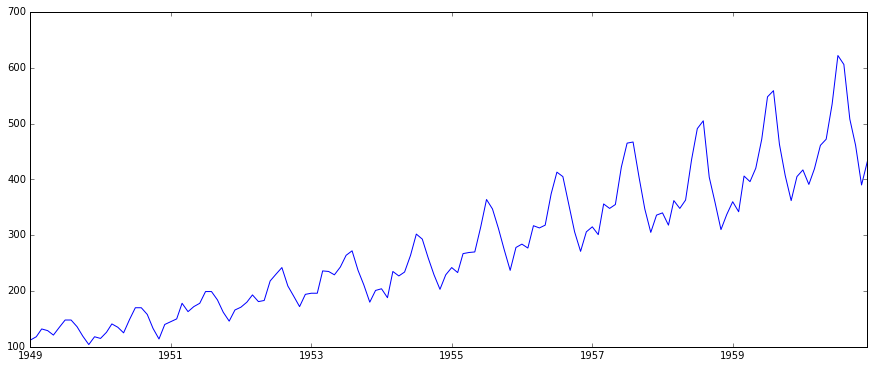

In [11]:
plt.plot(ts)

- There is an overall increasing trend in the data along with some seasonal variations.

# 2. Checking Stationarity of a Time Series

A TS is said to be stationary if its statistical properties such as mean, variance remain constant over time. But why is it important? Most of the TS models work on the assumption that the TS is stationary. Intuitively, we can sat that if a TS has a particular behaviour over time, there is a very high probability that it will follow the same in the future. Also, the theories related to stationary series are more mature and easier to implement as compared to non-stationary series.

Stationarity is defined using very strict criterion. However, for practical purposes we can assume the series to be stationary if it has constant statistical properties over time, ie. the following:

- constant mean
- constant variance
- an autocovariance that does not depend on time.


### Stationarity Series Test
1. **Plotting Rolling Statistics**: The moving average or moving variance and see if it varies with time. By moving average/variance I mean that at any instant ‘t’, we’ll take the average/variance of the last year, i.e. last 12 months. But again this is more of a visual technique.  
2. **Dickey-Fuller Test**: The null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary.  

In [12]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    
    print(dfoutput)

C:\Users\Kyu\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
C:\Users\Kyu\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


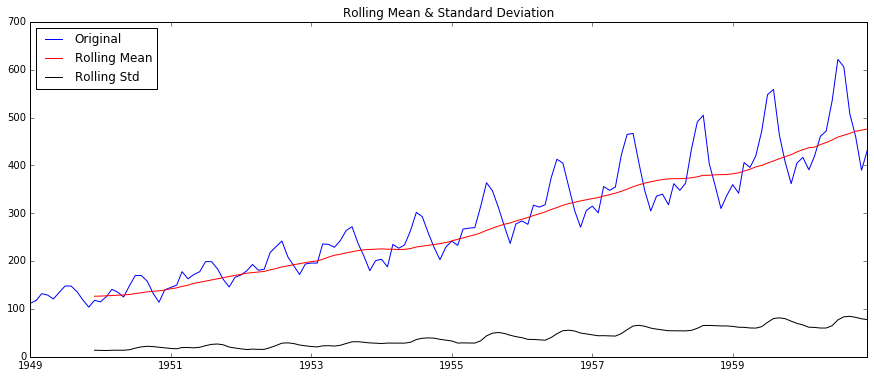

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (5%)             -2.884042
Critical Value (1%)             -3.481682
Critical Value (10%)            -2.578770
dtype: float64


In [13]:
test_stationarity(ts)

1. Not a stationary series because mean is increasing with time although the variation in standard deviation is small. 
2. The test statistic is way more than the critical values. 
    + Note that the signed values should be compared and not the absolute values.

## Time Series Stationary Properties

- Almost none of practical time series are stationary.
    + make a series perfectly stationary
    
### Non-stationary properties

- **Trend** – varying mean over time. For eg, in this case we saw that on average, the number of passengers was growing over time.
- **Seasonality** – variations at specific time-frames. eg people might have a tendency to buy cars in a particular month because of pay increment or festivals.  

### Steps
1. Estimating & Eliminating Trend
2. Eliminating Trend and Seasonality 
3. Forecasting a Time Series
4. Taking it back to original scale

# 3. Estimating & Eliminating Trend

- Penalize higher values more than smaller values by using **transformation** (log, square root, cube root, etc).

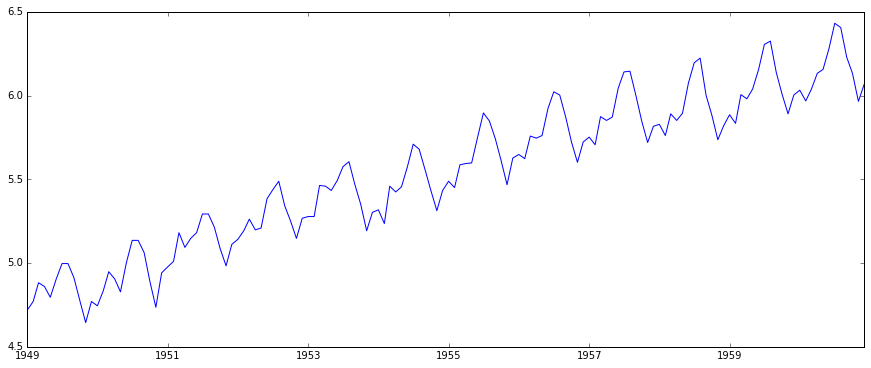

In [14]:
ts_log = np.log(ts)
plt.plot(ts_log)

- Remove the presence of noise by using following methods.

**Aggregation** : taking average for a time period like monthly/weekly averages  
**Smoothing** : taking rolling averages  
**Polynomial Fitting** : fit a regression model  

## Smoothing with MA
- Take the average over the past 1 year, i.e. last 12 values. 
    + Pandas has specific functions defined for determining rolling statistics.

C:\Users\Kyu\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  if __name__ == '__main__':


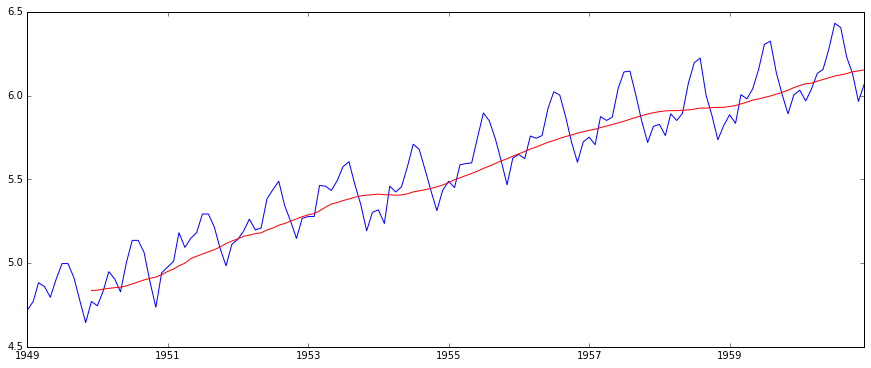

In [15]:
moving_avg = pd.rolling_mean(ts_log, 12)
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

The red line shows the rolling mean. Lets subtract this from the original series.

In [16]:
# since we are taking average of last 12 values, rolling mean is not defined for first 11 values.
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(12)

Month
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01         NaN
1949-08-01         NaN
1949-09-01         NaN
1949-10-01         NaN
1949-11-01         NaN
1949-12-01   -0.065494
Name: #Passengers, dtype: float64

In [17]:
# drop these NaN values
ts_log_moving_avg_diff.dropna(inplace=True)

### Stationarity Test

C:\Users\Kyu\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
C:\Users\Kyu\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


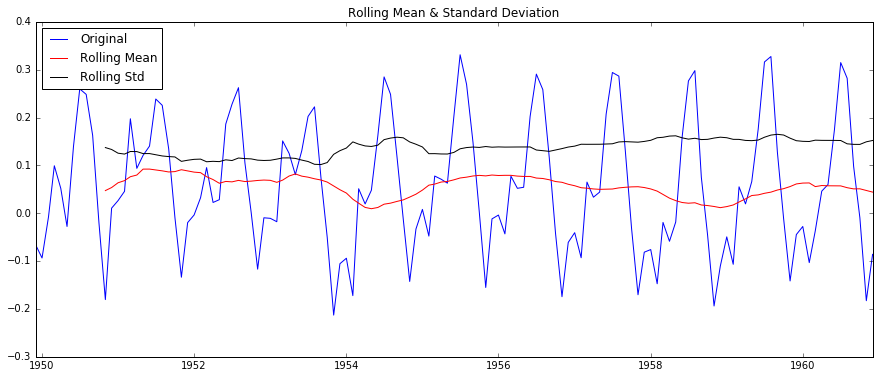

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (5%)             -2.886151
Critical Value (1%)             -3.486535
Critical Value (10%)            -2.579896
dtype: float64


In [18]:
test_stationarity(ts_log_moving_avg_diff)

- The rolling values appear to be varying slightly but there is no specific trend.
- The Dickey-Fuller test statistic is smaller than the 5% critical values meaning 95% confidence that this is a stationary series.

Note that in this case there will be no missing values as all values from starting are given weights. So it’ll work even with no previous values.

**Limitation**
- This particular approach is that the time-period has to be strictly defined. 
    + take a ‘weighted moving average’ where more recent values are given a higher weight.

## Smoothing with Exponentially Weighted Moving Average
- Weights are assigned to all the previous values with a decay factor.

C:\Users\Kyu\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(halflife=12,ignore_na=False,min_periods=0,adjust=True).mean()
  if __name__ == '__main__':


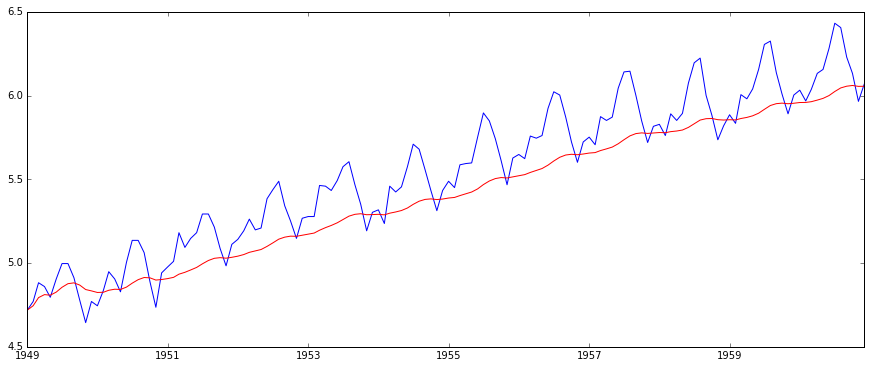

In [19]:
expwighted_avg = pd.ewma(ts_log, halflife=12)
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

**'halflife'** is to define the amount of exponential decay. Other parameters like **'span'** and **'center of mass'** can also be used to define decay.  

Now, let’s remove this from series and check stationarity:

### Stationarity Test

C:\Users\Kyu\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
C:\Users\Kyu\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


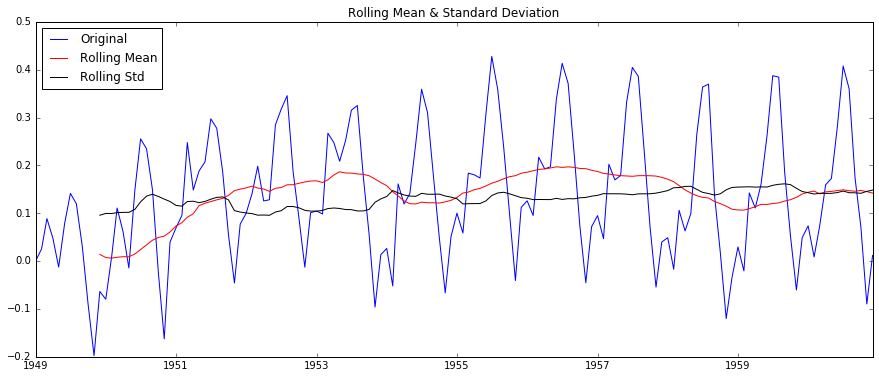

Results of Dickey-Fuller Test:
Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (5%)             -2.884042
Critical Value (1%)             -3.481682
Critical Value (10%)            -2.578770
dtype: float64


In [20]:
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)

- This TS has even lesser variations in mean and standard deviation in magnitude. 
- The Dickey-Fuller test statistic is smaller than the 1% critical value, which is better than the previous case.

Note that in this case there will be no missing values as all values from starting are given weights. So it’ll work even with no previous values.

# 4. Eliminating Trend and Seasonality

- Remove trend and high seasonality which simple trend reduction techniques couldn't handle.  

**Differencing** : taking the differece with a particular time lag.  
**Decomposition** : modeling both trend and seasonality and removing them from the model.  

## Differencing
Take the difference of the observation at a particular instant with that at the previous instant. This mostly works well in improving stationarity.

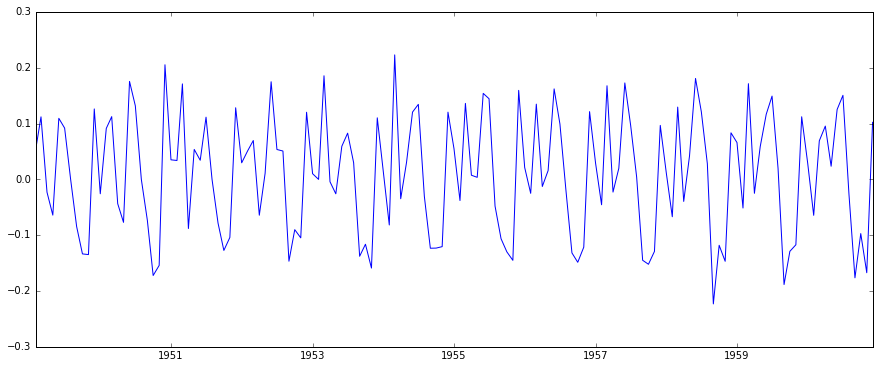

In [21]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

This appears to have reduced trend considerably. Lets verify using our plots:

### Stationarity Test

C:\Users\Kyu\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
C:\Users\Kyu\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


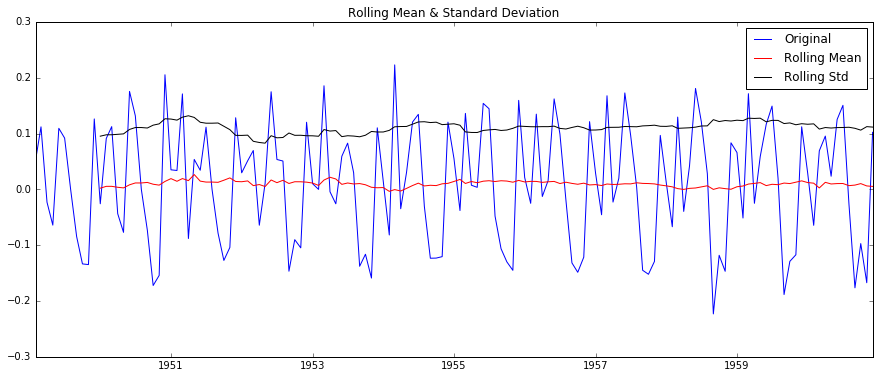

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (5%)             -2.884398
Critical Value (1%)             -3.482501
Critical Value (10%)            -2.578960
dtype: float64


In [22]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

- The mean and std variations have small variations with time. 
- The Dickey-Fuller test statistic is smaller than the 10% critical values meaning 90% confidence that this is a stationary series.


## Decomposing

- Both trend and seasonality are modeled separately and the remaining part of the series is returned.

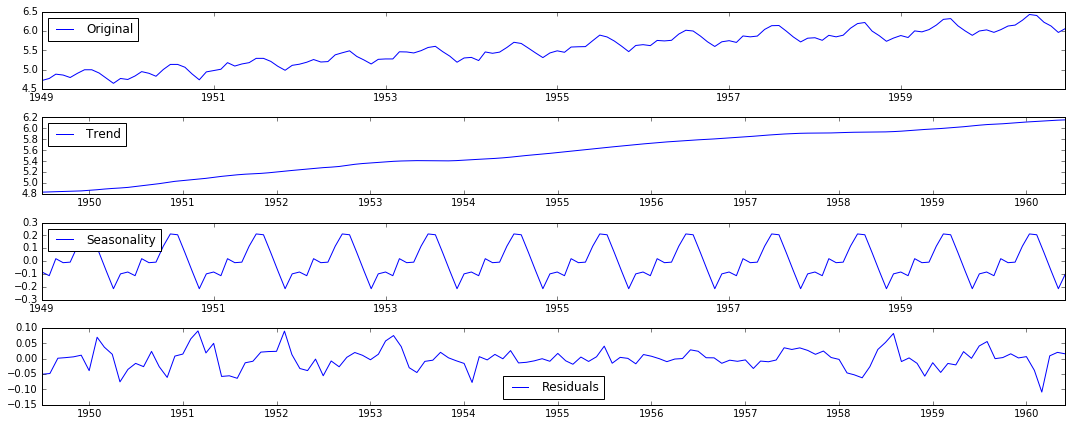

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()

### Stationarity Test

C:\Users\Kyu\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
C:\Users\Kyu\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


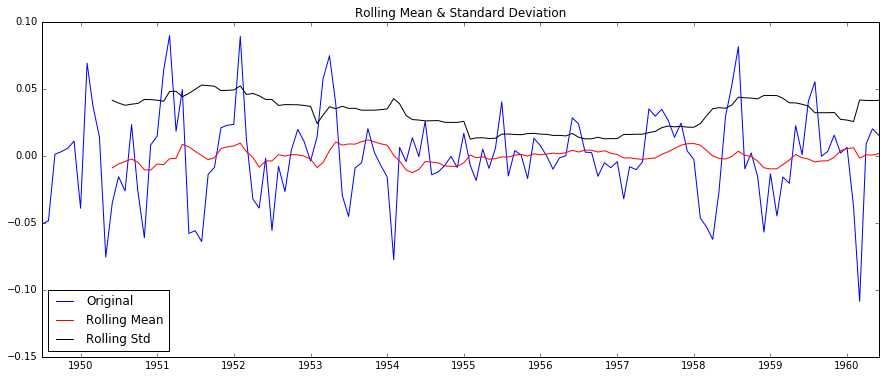

Results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (5%)           -2.885538e+00
Critical Value (1%)           -3.485122e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


In [24]:
# check stationarity of residuals
ts_log_decompose = residual

# remove missing value
ts_log_decompose.dropna(inplace=True)

# Dickey-Fuller test
test_stationarity(ts_log_decompose)

- The Dickey-Fuller test statistic is significantly lower than the 1% critical value. So this TS is very close to stationary.  

**TODO:**
- Try advanced decomposition techniques
    + Note: Converting the residuals into original values for future data in not very intuitive in this case.

# 5. Forecasting a Time Series

1. Make model on the TS after differencing as it is a very popular technique. 
2. Add noise and seasonality back into predicted residuals in this case. Having performed the trend and seasonality estimation techniques, there can be two situations:
    + A **strictly stationary series** with no dependence among the values. This is the easy case wherein we can model the residuals as white noise. But this is very rare.
    + A series with **significant dependence among values** by using statistical models such as ARIMA to forecast the data.

## ARIMA - Auto Regressive Integrated Moving Averages (linear regression)
The predictors depend on the parameters (p,d,q) of the ARIMA model
1. **Number of AR (Auto-Regressive) terms (p)**: Lags of dependent variable. If p is 5, the predictors for x(t) will be x(t-1)….x(t-5)
2. **Number of MA (Moving Average) terms (q)**: Lagged forecast errors in prediction equation. If q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.
3. **Number of Differences (d)**: The number of nonseasonal differences. Take the first order difference. So either we can pass that variable and put d=0 or pass the original variable and put d=1. Both will generate same results.  

**Goal** is to find the best value of ‘p’ and ‘q’ by using plots.
1. **Autocorrelation Function (ACF) - (q)**: A measure of the correlation between the the TS with a lagged version of itself. For instance at lag 5, ACF would compare series at time instant ‘t1’…’t2’ with series at instant ‘t1-5’…’t2-5’ (t1-5 and t2 being end points).
2. **Partial Autocorrelation Function (PACF) - (p)**: A measure the correlation between the TS with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons. Eg at lag 5, PACF would check the correlation but remove the effects already explained by lags 1 to 4.

### ACF and PACF

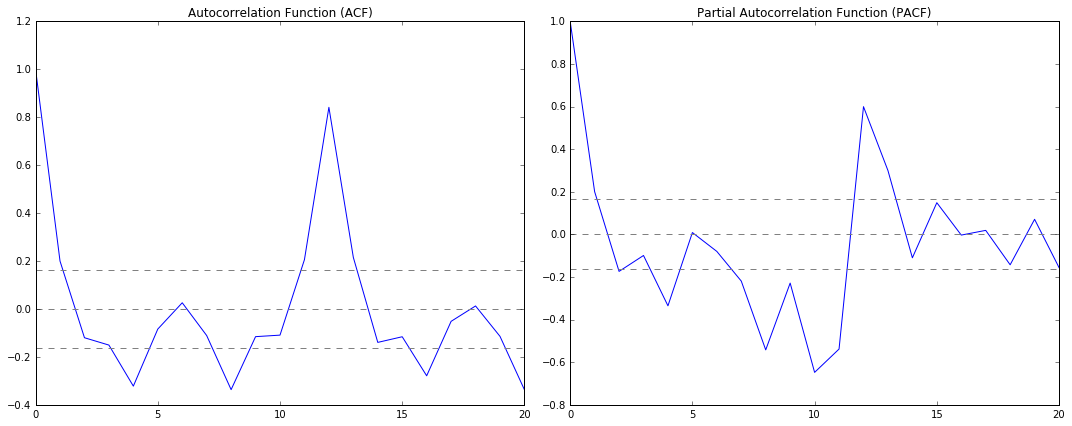

In [25]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
plt.title('Autocorrelation Function (ACF)')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()

In this plot, the two dotted lines on either sides of 0 are the confidence interevals.  
These can be used to determine the ‘p’ and ‘q’ values as:
- **p** – The lag value where the PACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case p=2.
- **q** – The lag value where the ACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case q=2.

## Build AR Model - (p)

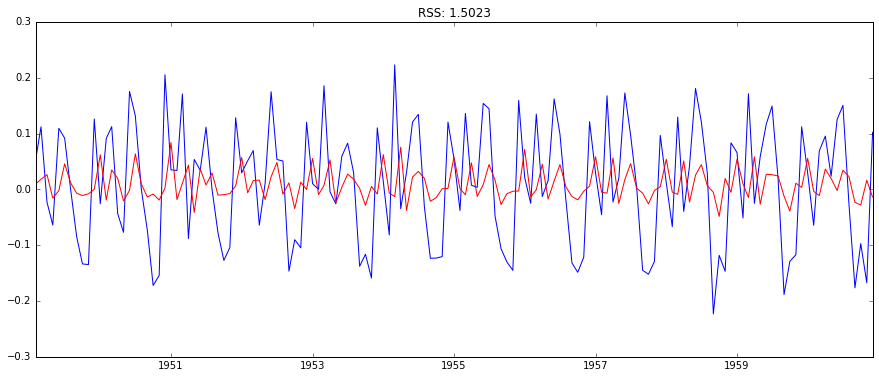

In [26]:
from statsmodels.tsa.arima_model import ARIMA

# p,d,q takes a tuple (p,d,q) in ARIMA
model = ARIMA(ts_log, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  

# plot
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

## Build MA Model - (q)

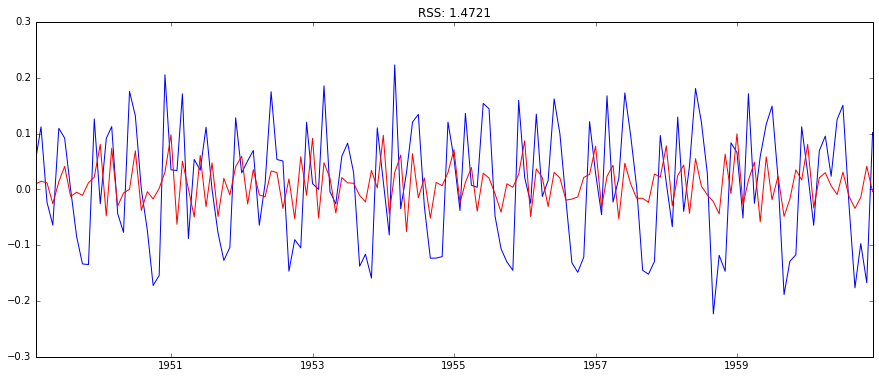

In [27]:
model = ARIMA(ts_log, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  

# plot
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))

## Build Combined Model

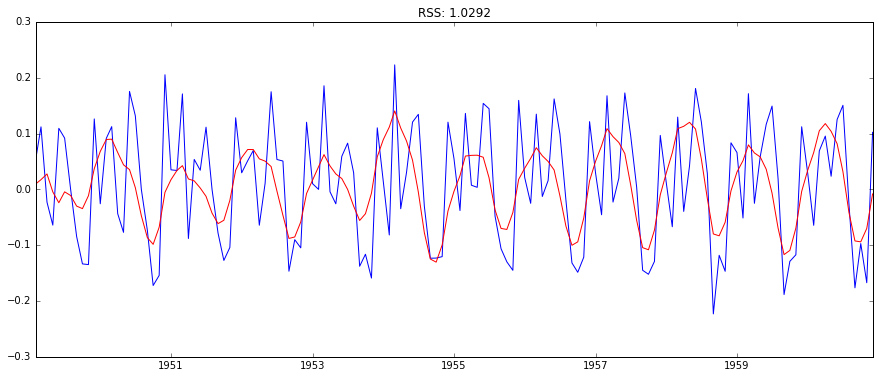

In [28]:
model = ARIMA(ts_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  

# plot
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

- The AR and MA models have almost the same RSS but combined model is significantly better

# 6. Taking it back to original scale

Since the combined model gave best result, lets scale it back to the original values.
- First step would be to store the predicted results as a separate series and observe it.

In [29]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023889
dtype: float64


- Notice that these start from ‘1949-02-01’ and not the first month due to taking a lag by 1
- The way to convert the differencing to log scale is to add these differences consecutively to the base number. 
    + An easy way to do it is to first determine the cumulative sum at index and then add it to the base number. 
    
The cumulative sum can be found as:

In [30]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
dtype: float64


- Next, add them to base number by creating a series with all values as base number then add the differences to it.  

This can be done as:

In [31]:
predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64

- Here the first element is base number itself and from thereon the values cumulatively added. 
- Last step is to take the exponent and compare with the original series.

This can be done as:

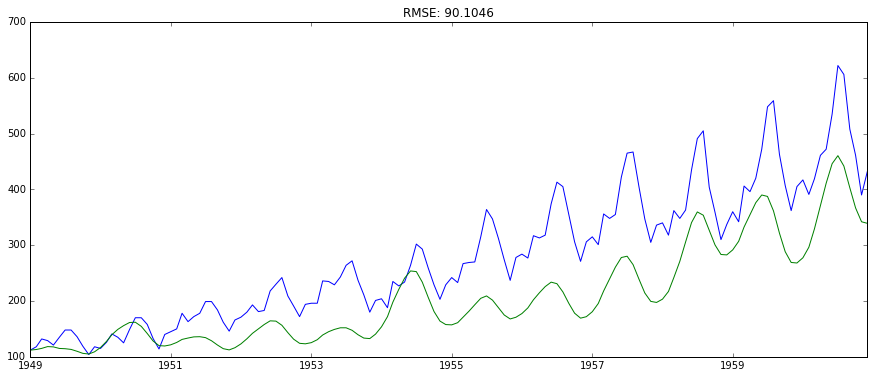

In [32]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)

# plot
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))

- Finally, a forecast at the original scale.